Tot slot gaan we kijken of we met dit model de richting van de koers kunnen voorspellen.
Door het model iets aan te passen kunnen we voorspellen of de koers gaat stijgen of dalen. Dat geeft hopelijk meer inzicht of dat het model daadwerkelijk beter werkt dan gewoon gokken.

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/Merijn68/BondTrading.git    
    %pip install -q "ray[tune]" bayesian-optimization
    %pip install loguru tensorflow-addons
    %cd BondTrading

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")

import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

from src.data import make_dataset, window, split
from src.models import evaluate, hyper
from src.models.base_model import RnnUpDownModel
from src.visualization import visualize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df_isin = make_dataset.read_pkl('isin', path = Path("data/processed/"), colab = IS_COLAB)
# subset columns and sort on index
df_isin = df_isin[['rate_dt','mid','estimated_bondprice','term_spread','bid_offer_spread_10','10 YEARS']]
df_isin.columns = ['rate_dt','mid','estimated_bondprice','term_spread','bid_offer_spread_10y','inflation_10y']
df_isin = df_isin.set_index('rate_dt')
df_isin = df_isin.sort_index()

2022-02-02 23:26:08.997 | INFO     | src.data.make_dataset:read_pkl:373 - Load preprocessed isin data


Een optie is om hier de data om te vormen naar de eerste afgeleide. Aangezien we vooral geintereseerd zijn in het verschil tussen de huidige bondkoers en de bondkoers van 10 dagen geleden.

In [6]:
horizon = 10
# unclear if % change should be for all columns or only for price?
df_isin = df_isin.pct_change(periods = horizon)
df_isin.replace([np.inf, -np.inf], np.nan, inplace=True)
df_isin = df_isin.dropna()
df_isin.head()

,mid,estimated_bondprice,term_spread,bid_offer_spread_10y,inflation_10y
rate_dt,,,,,
2016-06-15,0.008648,0.009363,-0.058411,-0.299566,-0.048013
2016-06-16,0.007935,0.008361,-0.050833,-0.276946,-0.058140
2016-06-17,0.000735,0.001181,0.022312,-0.044983,-0.043551
2016-06-20,0.001968,0.001186,0.014060,-0.042553,-0.030050
2016-06-21,0.000596,-0.000884,0.056445,0.035714,-0.030000


In [7]:
df_train, df_test = split.split_data(df_isin, 0.7)
scaler = MinMaxScaler()
df_train[df_train.columns] = scaler.fit_transform(df_train[df_train.columns])
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns])

2022-02-02 23:26:14.559 | INFO     | src.data.split:split_data:19 - Train test split data 1402 70.0%,train data 981, test data 421.


Nu moet het model dus de bewegingen van de bondprijzen over 10 dagen gaan voorspellen.

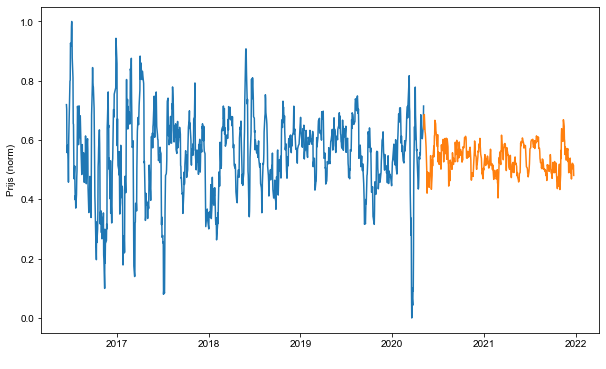

In [8]:
visualize.timeplot(
    df_train['mid'], 
    df_test['mid'], 
    x_label = ' ',
    y_label = 'Prijs (norm)',
    figurepath = Path("reports/figures"), 
    name = 'timeseries traintestsplit')
plt.show()

In [9]:
window_size = 32 
batch_size = 32
shuffle_buffer = 4
train_set = window.windowed_dataset(df_train, window_size, batch_size, shuffle_buffer, skip = horizon - 1, horizon=1)
valid_set = window.windowed_dataset(df_test, window_size, batch_size, shuffle_buffer, skip = horizon - 1, horizon=1)

x, y = next(iter(train_set))
x.shape, y.shape

2022-02-02 23:26:20.414 | INFO     | src.data.window:windowed_dataset:14 - Split windowed dataset window_size = 32 batch_size =  32, shuffle_buffer =  4 ,horizon =  1
2022-02-02 23:26:22.094 | INFO     | src.data.window:windowed_dataset:14 - Split windowed dataset window_size = 32 batch_size =  32, shuffle_buffer =  4 ,horizon =  1


(TensorShape([32, 32, 5]), TensorShape([32, 1]))

In [10]:
# Remove log files before tuning models
if IS_COLAB:
  !rm -rf logs/
else:
  !del logs /Q
  !del %USERPROFILE%\AppData\Local\Temp\.tensorboard-info\*.* /Q

%load_ext tensorboard

In [11]:
%tensorboard --logdir logs

Omdat we nu de beweging, op of neer - 10 dagen later voorspellen, kunnen we gewoon gebruik maken van de MAPE, en MAE.

In [12]:
y, yhat = evaluate.naivepredict(df_train['mid'].values)
norm = evaluate.mae(y, yhat)
print('1 step Mean Absolute Error: ', evaluate.mae(y, yhat))

1 step Mean Absolute Error:  0.043449551463284684


In [13]:
result = {}
models = {}
reduce_lr = ReduceLROnPlateau(monitor="mse", factor=0.8,
                              patience=5, min_lr=1e-5)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

key = "Adam"
name = f"16_RNN_NO_CONV_{key}"
logdir = Path("logs") / name
tb = TensorBoard(logdir, histogram_freq=1)

config = {
    'window'        :   window_size,        
    'units'         :   16,    
    'hidden'        :   1,        
    'horizon'       :   1,   
    'features'      :   5 
}
model = RnnUpDownModel(name,config)
opt = tf.keras.optimizers.get(key)
opt.momentum = 0.9
opt.learning_rate = 0.01

model.compile(
  optimizer=opt,
  loss='mse', 
  metrics=['mse','mae', 'mape'])
result[name] = model.fit(train_set,epochs=200,callbacks=[tb, early_stop, reduce_lr],
                        validation_data=valid_set, verbose=0)
models[name] = model
print("Model: " + model.name, model.evaluate(valid_set))

12/12 [==============================] - 0s 24ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0369 - mape: 7.0259
Model: 16_RNN_NO_CONV_Adam [0.001969580538570881, 0.001969580538570881, 0.036943044513463974, 7.025912284851074]


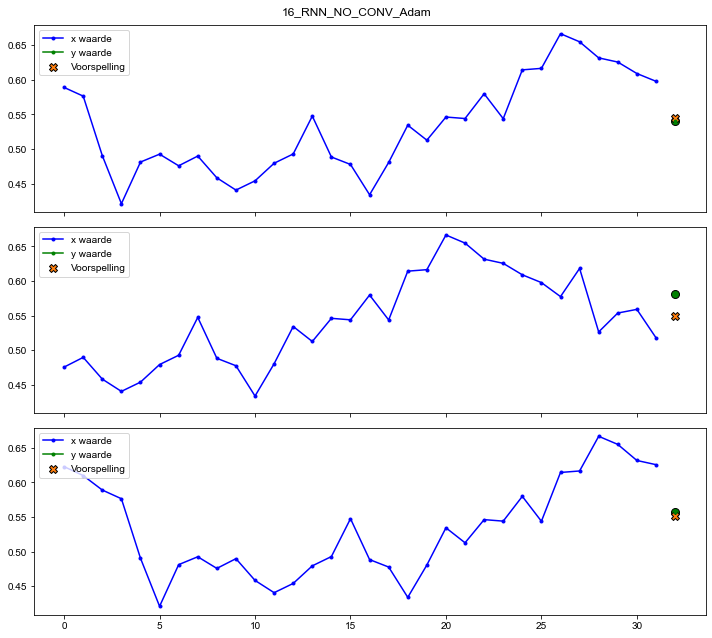

In [14]:
fig = visualize.plot_example( 
    valid_set,
    window_size = window_size,
    horizon = 1,
    examples = 3,
    model = model,
    figurepath = Path("reports/figures"))

100%|██████████| 389/389 [00:25<00:00, 15.31it/s]


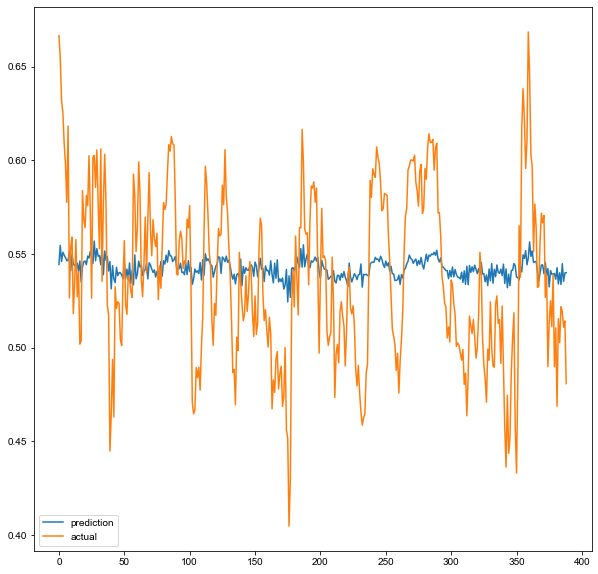

In [15]:
from src.models import evaluate
pred = evaluate.generate_prediction(model, df_test, window = window_size, horizon = 1)

De laatste grafiek laat duidelijk zien dat hoewel het model beter presteert dan de naive voorspelling het model niet goed in staat is om de bewegelijkheid van de bondprijzen te voorspellen. Mogelijk zouden we nog meer data hierbij kunnen betrekken of een complexer model kiezen dat beter om kan gaan met de tijdsdimensionaliteit.

In dit ondezoek zien we echter dat het toevoegen van meer complexiteit niet heeft geholpen om tot betere voorspellingen te komen.




